## Euler-Maruyama

In [28]:
%matplotlib inline
import configparser
import matplotlib.pyplot as plt
import numpy as np
import quandl

config = configparser.ConfigParser()
config.read('keys.ini')

['keys.ini']

In [32]:
# start = "2016-01-01"
# end = "2016-12-31"

# quandl.ApiConfig.api_key = config['quandl']['key']
# df = quandl.get("WIKI/AMZN", start_date=start, end_date=end)
# df.head()
# adj_close = df['Adj. Close']
# t_adj_close = np.linspace(1, len(adj_close), len(adj_close))

In [33]:
def compute_drift_and_volatility(adj_close):
    returns = []
    for i in range(len(adj_close) - 1):
        daily_return = (adj_close[i + 1] - adj_close[i]) / adj_close[i]
        returns.append(daily_return)
    
    mu = np.mean(returns)
    sigma = np.std(returns)
    
    return mu, sigma

In [34]:
# Model parameters
mu, sigma = compute_drift_and_volatility(adj_close)
print(mu, sigma)

0.000817863667254033 0.018346033257953476


In [35]:
# Simulation parameters
n = 2.**8
T = 252.
dt = T / n
t = np.linspace(0., T, int(n))

In [36]:
sqrtdt = np.sqrt(dt)

In [37]:
s = np.zeros(int(n))
a = np.zeros(int(n))

In [38]:
s[0], a[0] = adj_close[0], adj_close[0]

In [39]:
def gbm(n, dt):
    b = np.random.normal(0, 1, int(n))
    w = np.cumsum(b)
    return w, b

In [40]:
w, b = gbm(n, dt)

for i in range(int(n) - 1):
    s[i + 1] = s[i] + mu * s[i] * dt + sigma * sqrtdt * s[i] * b[i]

    drift = (mu - 0.5 * sigma**2) * (i + 1) * dt
    diffusion = sigma * np.sqrt(dt) * w[i]
    a[i + 1] = a[0] * np.exp(drift + diffusion)

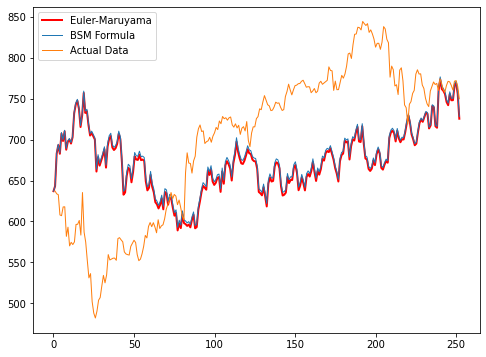

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(t, s, lw=2, color='r')
ax.plot(t, a, lw=1)
ax.plot(t_adj_close, np.ravel(adj_close), lw=1)
ax.legend(['Euler-Maruyama', 'BSM Formula', 'Actual Data'])